In [13]:
import torch
import random
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from IPython.display import display

### Глобальные параметры

In [14]:
SEED = 7
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
plt.rcParams["figure.figsize"] = (30,10)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

### Параметры обучения

In [15]:
BATCH_SIZE = 40
EPOCHS = 100
LR = 2e-4
B1 = 0.5
B2= 0.999
NUM_WORKERS = 4
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Пути

In [16]:
DATASET_PATH = "../Datasets/LUDB/i_ii_avf_v4_v5_v6_leads_3_complexes.json"
G_MODEL_PATH = f"../Models/FewComplexes/Pytorch/Denoised/G_b{BATCH_SIZE}_e{EPOCHS}.pt"
D_MODEL_PATH = f"../Models/FewComplexes/Pytorch/Denoised/D_b{BATCH_SIZE}_e{EPOCHS}.pt"
CHECKPOINT_PATH = f"../Models/FewComplexes/Pytorch/Denoised/G_b{BATCH_SIZE}_e{EPOCHS}.pt"

### Параметры модели

In [17]:
discriminator_input_size = 768
DATA = pd.read_json(DATASET_PATH)

### Дискриминатор

In [18]:
class Discriminator(torch.nn.Module):
    def __init__(self, discriminator_input_size):
        super(Discriminator, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(discriminator_input_size, 512),
            torch.nn.LeakyReLU(0.2, inplace=True),

            torch.nn.Linear(512, 256),
            torch.nn.LeakyReLU(0.2, inplace=True),
            
            torch.nn.Linear(256, 1),
            torch.nn.Sigmoid(),
        )

    def forward(self, x):
        out = self.model(x)
        return out

### Генератор

In [19]:
class DenoisedGenerator(torch.nn.Module):
    def __init__(self, discriminator_input_size):
      super(DenoisedGenerator, self).__init__()

      self.discriminator_input_size = discriminator_input_size

      self.model = torch.nn.Sequential(
          torch.nn.Linear(100, 128),
          torch.nn.LeakyReLU(0.2, inplace=True),

          torch.nn.Linear(128, 256),
          torch.nn.BatchNorm1d(256, 0.8),
          torch.nn.LeakyReLU(0.2, inplace=True),

          torch.nn.Linear(256, 512),
          torch.nn.BatchNorm1d(512, 0.8),
          torch.nn.LeakyReLU(0.2, inplace=True),

          torch.nn.Linear(512, 1024),
          torch.nn.BatchNorm1d(1024, 0.8),
          torch.nn.LeakyReLU(0.2, inplace=True),

          torch.nn.Linear(1024, self.discriminator_input_size),
          torch.nn.Tanh(),
      )
      self.convs_1d = torch.nn.Sequential(
          torch.nn.Conv1d(1, 16, kernel_size=9, stride=1, padding=4),
          torch.nn.Tanh(),
          torch.nn.Conv1d(16, 16, kernel_size=9, stride=1, padding=4),
          torch.nn.Tanh(),
          torch.nn.Conv1d(16, 1, kernel_size=9, stride=1, padding=4))

    def forward(self, x):
        out = self.model(x)
        out = out.unsqueeze(1)
        out = self.convs_1d(out)
        out = out.squeeze()
        return out

Train loop

In [20]:
def train_one_epoch(discriminator,
                    generator,
                    dataloader,
                    D_optimizer,
                    G_optimizer,
                    loss,
                    epoch,
                    device=torch.device('cpu')):

    for img, _ in (pbar := tqdm(dataloader)):

        # Training the discriminator
        real_inputs = img
        real_outputs = discriminator(real_inputs)
        real_label = torch.ones(real_inputs.shape[0], 1, device=device)

        noise = torch.normal(0, 1, size=(real_inputs.shape[0], 100), device=device)

        fake_inputs = generator(noise)
        fake_outputs = discriminator(fake_inputs)
        fake_label = torch.zeros(fake_inputs.shape[0], 1, device=device)

        outputs = torch.cat((real_outputs, fake_outputs), 0)
        targets = torch.cat((real_label, fake_label), 0)

        D_loss = loss(outputs, targets)
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # Training the generator
        noise = torch.normal(0, 1, size=(real_inputs.shape[0], 100), device=device)

        fake_inputs = generator(noise)
        fake_outputs = discriminator(fake_inputs)
        fake_targets = torch.ones([fake_inputs.shape[0], 1], device=device)

        G_loss = loss(fake_outputs, fake_targets)
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        pbar.set_description(
            f'Eposh: {epoch}\tD_loss: {D_loss:,.3f}\tG_loss: {G_loss:,.3f}')


In [21]:
def train_model(discriminator,
          generator,
          dataloader,
          D_optimizer,
          G_optimizer,
          loss,
          epochs,
          device=torch.device('cpu'),
          D_save_path=None,
          G_save_path=None):

    for epoch in range(epochs):
        train_one_epoch(discriminator, generator, dataloader, D_optimizer,
                        G_optimizer, loss, epoch, device)


    torch.save(discriminator.state_dict(),
                D_save_path)
    torch.save(generator.state_dict(),
                G_save_path)


### Обучение модели

In [22]:
loss = torch.nn.BCELoss().to(DEVICE)

G = DenoisedGenerator(discriminator_input_size).to(DEVICE)
D = Discriminator(discriminator_input_size).to(DEVICE)

G_optimizer = torch.optim.Adam(G.parameters(), lr=LR, betas=(B1, B2))
D_optimizer = torch.optim.Adam(D.parameters(), lr=LR, betas=(B1, B2))

In [23]:
dataset = TensorDataset(
    torch.Tensor(DATA["esg"]).to(DEVICE),
    torch.ones_like(torch.Tensor(DATA["esg"])).to(DEVICE))
dataloader = DataLoader(dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        drop_last=True)


In [24]:
train_model(D, G, dataloader, D_optimizer, G_optimizer, loss, EPOCHS, DEVICE, D_MODEL_PATH, G_MODEL_PATH)

Eposh: 99	D_loss: 0.366	G_loss: 2.777: 100%|██████████| 62/62 [00:00<00:00, 90.97it/s]


### Результаты работы модели

In [25]:
denoised_generator = DenoisedGenerator(discriminator_input_size).cpu()
denoised_generator.load_state_dict(torch.load(CHECKPOINT_PATH))
denoised_generator.eval()

DenoisedGenerator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=768, bias=True)
    (12): Tanh()
  )
  (convs_1d): Sequential(
    (0): Conv1d(1, 16, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): Tanh()
    (2): Conv1d(16, 16, kernel_size=

In [26]:
num_samples = 10
noise = torch.normal(0, 1, size=(num_samples, 100))
denoised_generated_ecg = denoised_generator(noise).detach().cpu()
ludb_random_samples = random.choices(DATA["esg"], k=num_samples)

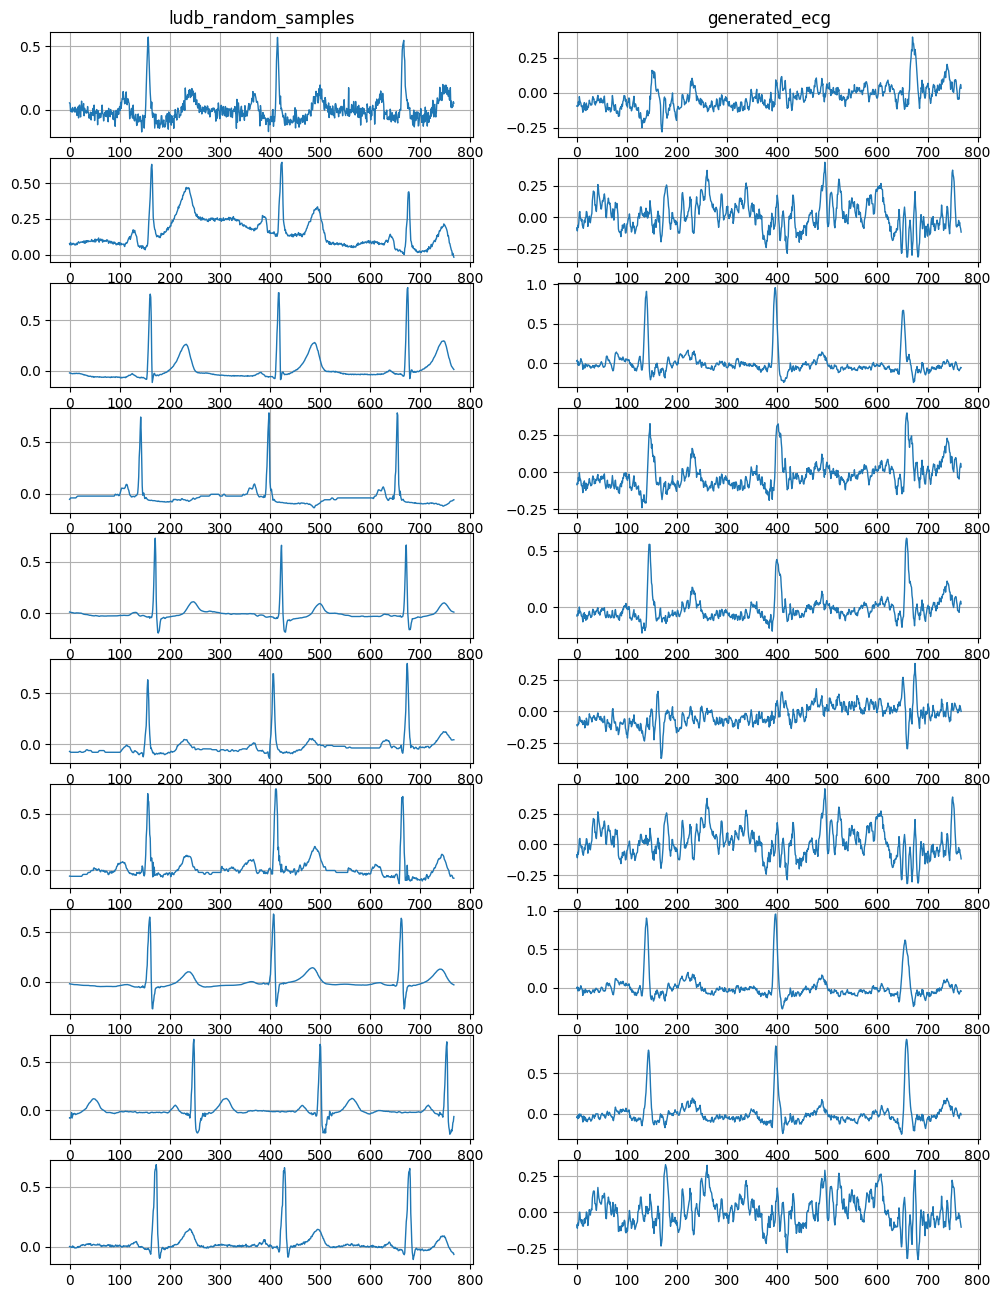

In [27]:
n_cols = 2
n_rows = num_samples

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 16))

axes[0, 0].set_title(f"ludb_random_samples")
axes[0, 1].set_title(f"generated_ecg")


for i in range(n_rows):
    axes[i, 0].plot(ludb_random_samples[i])
    axes[i, 1].plot(denoised_generated_ecg[i])